# Assignment 2 - Multi-Label Classification

**ABOUT**  
In this assignment, the dataset contains of around 3000 movie posters based on which it's genres are to be identified.

The number of movie posters available is 3036.  
The csv file however contains almost 40,000 movie metadata. Therefore, only the metadata of the available movie posters is to be used. Further, we need to remove the least frequent movie genres as well as any empty data samples.

### Part 1 - Downloading dataset and splitting into training and test set

In [1]:
!pip install --upgrade tensorflow_hub

     |████████████████████████████████| 108 kB 2.9 MB/s eta 0:00:01
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/tensorflow2_p36/bin/python -m pip install --upgrade pip' command.


In [2]:
import re
import logging
#from datetime import datetime
#import time

#import learning_curves

import numpy as np
from numpy import expand_dims

import pandas as pd

import os
from os import listdir

import seaborn as sns

import matplotlib.pyplot as plt
import matplotlib.style as style
import matplotlib.image as mpimg
%matplotlib inline

import tensorflow as tf
import tensorflow_hub as hub

from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.calibration import calibration_curve

from keras.preprocessing import image
from PIL import Image
from tensorflow.keras import layers

BATCH_SIZE = 32 
AUTOTUNE = tf.data.experimental.AUTOTUNE
SHUFFLE_BUFFER_SIZE = 1024
Channels = 3
Image_Size = 224
N_LABELS = 18

Using TensorFlow backend.


**NOTE:** I changed the batch size from 256 to 32 since the kernel kept having to restart with the large batch size

Function to take input as the path to folder containing the images and the path to csv file. Returns the metadata as a dataframe, image ID (as is in the csv file), image paths to all the movie posters

In [3]:
def get_data(IPath, CSVPath):
    
    #Reading CSV file
    data = pd.read_csv(CSVPath, encoding = "ISO-8859-1")
    
    #Removing empty rows
    data.dropna(subset=['imdbId', 'Genre', 'Poster'], inplace=True)
    
    #Romoving the genre 'Adult'
    data.drop(data[data['Genre'].str.contains('Adult')].index, inplace=True)
    
    #Removing the least frequent labels
    label_freq = data['Genre'].apply(lambda s: str(s).split('|')).explode().value_counts().sort_values(ascending=False)
    rare = list(label_freq[label_freq<1000].index)
    data['Genre'] = data['Genre'].apply(lambda s: [l for l in str(s).split('|') if l not in rare])
    
    #Getting the IMDB ID of all available movie posters from local folder
    imageID = []
    
    for f in os.listdir(imgPath):
        imageID.append(f[3:-4])
        
    imageID = np.array(imageID)
    
    #Getting the data of only the available movie posters
    movies = data[data['imdbId'].isin(imageID)]
    imageID = movies['imdbId']
    imageID.to_numpy()
    
    #Making sure the length of the ID matches how it is in folder
    ID = []
    
    for i in imageID:
        temp = str(i)
        if (len(temp) == 5):
            temp = '0'+temp
        ID.append(temp)
    
    #Getting the image path of the movie posters
    imagePaths = []
    
    for i in ID:
        imagePaths.append(imgPath+'/tt0'+i+'.jpg')
        
    return movies, imageID, imagePaths

Function ot preprocess the data. This function reads the image file from the given file path and converts it to the required format

In [4]:
def parse_func(imagePath, label):
    
    image_string = tf.io.read_file(imagePath)
    image_decoded = tf.image.decode_jpeg(image_string, channels=Channels)
    image_resized = tf.image.resize(image_decoded, [Image_Size, Image_Size])
    image_normalized = image_resized / 255.0
       
    return image_normalized, label

This function creates a dataset from given file path and labels

In [5]:
def create_dataset(filenames, labels):
    
    dataset = tf.data.Dataset.from_tensor_slices((filenames, labels))
    dataset = dataset.map(parse_func, num_parallel_calls=AUTOTUNE)
    dataset = dataset.cache()
    dataset = dataset.shuffle(buffer_size=SHUFFLE_BUFFER_SIZE)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(buffer_size=AUTOTUNE)
    
    return dataset

---

In [6]:
#Path to folder containing all the movie posters:
imgPath = '/home/ec2-user/SageMaker/Movie/MovieData'

#Path to csv file containing all metadata corresponding to movie posters
csvPath = '/home/ec2-user/SageMaker/MovieGenre.csv'

In [7]:
movie_data, ID, iPaths = get_data(imgPath, csvPath)

In [8]:
#Creating array of labels:
labels = movie_data['Genre']
mlb = MultiLabelBinarizer()
mlb.fit(labels)
labels = mlb.transform(labels)

In [9]:
#Splitting the data inti training and testing
X_train, X_val, y_train, y_val = train_test_split(iPaths, labels, test_size=0.2, random_state=44)

In [10]:
#Creating dataset each for training and testing
train_ds = create_dataset(X_train, y_train)
val_ds = create_dataset(X_val, y_val)

In [11]:
for f, l in train_ds.take(1):
    print("Shape of features array:", f.numpy().shape)
    print("Shape of labels array:", l.numpy().shape)

Shape of features array: (32, 224, 224, 3)
Shape of labels array: (32, 18)


---

### Part 2 - Making the model

For this classifier, a pre-trained instance of **MobileNet V2** is going to be used, on top of which a new classfier will be added. The new classification head will be trained from scratch so that we can repurpose the objective to multi-label classfication task.  
The pretrained instance has a depth multiplier of 1.0.  
The depth multipliers signifies the number of hidden layers

**Layers in the model:**  
1. The layer from the pre trained instance
2. Dense Layer (Fully-Connected layer with ReLu Activation)
3. Final layer = Dense Layer

The MobileNet model is based on depthwise separable convolutions.  
Pro's:  
- reduces computaions
- reduces model size

Function used to extract the model:  
**hub.KerasLayer** - Wraps a SavedModel as a Keras Layer.  

In [12]:
url = "https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/4"
feature_extractor_layer = hub.KerasLayer(url, input_shape=(Image_Size,Image_Size,Channels))

In [13]:
#Freezing the parameters
feature_extractor_layer.trainable = False

In [14]:
model = tf.keras.Sequential([
    feature_extractor_layer,
    layers.Dense(1024, activation='relu', name='hidden_layer'),
    layers.Dense(N_LABELS, activation='sigmoid', name='output')
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1280)              2257984   
_________________________________________________________________
hidden_layer (Dense)         (None, 1024)              1311744   
_________________________________________________________________
output (Dense)               (None, 18)                18450     
Total params: 3,588,178
Trainable params: 1,330,194
Non-trainable params: 2,257,984
_________________________________________________________________


---

### Part 3 - Loss Function

Since the problem is of maulti-label classification, the prediction giving out by the model will be like a probability matrix.  
Two cost functions will be used for the evaluation:
1. Macro soft-F1 score
2. Binary cross-entropy loss.

**1. Macro soft-F1 score**  
This is a modified version of the F1-score to make it differentiable. This is done by computing the number of True Positives, False Positives, False Negatives as a continuous sum of likelihood values by using probabilities without applying any threshold.  
Further, a default evaluation metric is also to be defined, with a threshold of 0.5

**Function below:**  
  
**Input:**  
- y = true labels
- y_hat = probability matrix
  
**Returns:**
- macro_cost = value of cost function for the batch

In [15]:
@tf.function
def macro_soft_f1(y, y_hat):
    y = tf.cast(y, tf.float32)
    y_hat = tf.cast(y_hat, tf.float32)
    tp = tf.reduce_sum(y_hat * y, axis=0)
    fp = tf.reduce_sum(y_hat * (1 - y), axis=0)
    fn = tf.reduce_sum((1 - y_hat) * y, axis=0)
    soft_f1 = 2*tp / (2*tp + fn + fp + 1e-16)
    cost = 1 - soft_f1 # reduce 1 - soft-f1 in order to increase soft-f1
    macro_cost = tf.reduce_mean(cost) # average on all labels
    return macro_cost

- **tf.cast** : Typecasting function
- **tf.reduce_sum** : Reduces the element-wise addition along a defined axis
- **tf.greater** : returns 1 if y_hat > threshold value

In [16]:
@tf.function
def macro_f1(y, y_hat, thresh=0.5):
    y_pred = tf.cast(tf.greater(y_hat, thresh), tf.float32)
    tp = tf.cast(tf.math.count_nonzero(y_pred * y, axis=0), tf.float32)
    fp = tf.cast(tf.math.count_nonzero(y_pred * (1 - y), axis=0), tf.float32)
    fn = tf.cast(tf.math.count_nonzero((1 - y_pred) * y, axis=0), tf.float32)
    f1 = 2*tp / (2*tp + fn + fp + 1e-16)
    macro_f1 = tf.reduce_mean(f1)
    return macro_f1

---

### Part 4 - Training the model with macro_soft_f1

In [17]:
LR = 1e-5 # Keep it small when transfer learning
EPOCHS = 30

In [18]:
model.compile(
  optimizer=tf.keras.optimizers.Adam(learning_rate=LR),
  loss=macro_soft_f1,
  metrics=[macro_f1])

In [19]:
history = model.fit(train_ds,
                    epochs=EPOCHS,
                    validation_data=val_ds)

Train for 76 steps, validate for 19 steps
Epoch 1/30
76/76 [==============================] - 49s 650ms/step - loss: 0.8123 - macro_f1: 0.1842 - val_loss: 0.8055 - val_macro_f1: 0.1959
Epoch 2/30
76/76 [==============================] - 37s 481ms/step - loss: 0.7995 - macro_f1: 0.2114 - val_loss: 0.7995 - val_macro_f1: 0.2059
Epoch 3/30
76/76 [==============================] - 36s 479ms/step - loss: 0.7940 - macro_f1: 0.2226 - val_loss: 0.7962 - val_macro_f1: 0.2148
Epoch 4/30
76/76 [==============================] - 36s 478ms/step - loss: 0.7899 - macro_f1: 0.2344 - val_loss: 0.7935 - val_macro_f1: 0.2227
Epoch 5/30
76/76 [==============================] - 37s 481ms/step - loss: 0.7854 - macro_f1: 0.2467 - val_loss: 0.7902 - val_macro_f1: 0.2384
Epoch 6/30
76/76 [==============================] - 39s 515ms/step - loss: 0.7785 - macro_f1: 0.2628 - val_loss: 0.7863 - val_macro_f1: 0.2315
Epoch 7/30
76/76 [==============================] - 37s 481ms/step - loss: 0.7716 - macro_f1: 0.2676

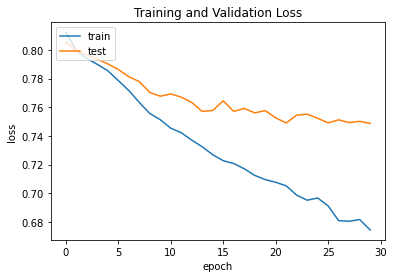

In [20]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Training and Validation Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left') 

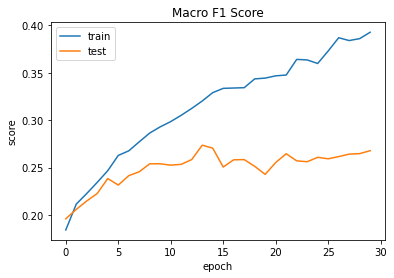

In [21]:
plt.plot(history.history['macro_f1'])
plt.plot(history.history['val_macro_f1'])
plt.title('Macro F1 Score')
plt.ylabel('score')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

In [22]:
val_loss = history.history['val_loss']
val_macro_f1 = history.history['val_macro_f1']

print("Macro soft-F1 loss: %.2f" %val_loss[-1])
print("Macro F1-score: %.2f" %val_macro_f1[-1])

Macro soft-F1 loss: 0.75
Macro F1-score: 0.27


---

### Part 5 - Show Predictions

In [23]:
def show_prediction(title, data, model):
    
    #Getting the path to the movie poster along with the true corresponding genre
    imdbId = movie_data.loc[movie_data['Title']==title]['imdbId'].iloc[0]
    
    temp = str(imdbId)
    if (len(temp) == 5):
        temp = '0'+temp
        
    imdbId = '/tt0'+temp+'.jpg'
    img_path = imgPath + imdbId
    
    genre = movie_data.loc[movie_data['Title']==title]['Genre'].iloc[0]
    
    #Loading the image from image path
    img = image.load_img(img_path, target_size=(Image_Size,Image_Size,Channels))
    img = image.img_to_array(img)
    img = img/255
    img = np.expand_dims(img, axis=0)
    
    #Predicting the genre of the movie
    prediction = (model.predict(img) > 0.5).astype('int')
    prediction = pd.Series(prediction[0])
    prediction.index = mlb.classes_
    prediction = prediction[prediction==1].index.values
    
    #Displaying the movie poster along with the predicted genre
    style.use('default')
    plt.figure(figsize=(8,4))
    plt.imshow(Image.open(img_path))
    plt.title('\n\n{}\n\nGenre\n{}\n\nPrediction\n{}\n'.format(title, genre, list(prediction)), fontsize=9)
    plt.show()

In [24]:
movie_data.head()

,imdbId,Imdb Link,Title,IMDB Score,Genre,Poster
0,114709,http://www.imdb.com/title/tt114709,Toy Story (1995),8.3,"[Animation, Adventure, Comedy]",https://images-na.ssl-images-amazon.com/images...
1,113497,http://www.imdb.com/title/tt113497,Jumanji (1995),6.9,"[Action, Adventure, Family]",https://images-na.ssl-images-amazon.com/images...
2,113228,http://www.imdb.com/title/tt113228,Grumpier Old Men (1995),6.6,"[Comedy, Romance]",https://images-na.ssl-images-amazon.com/images...
3,114885,http://www.imdb.com/title/tt114885,Waiting to Exhale (1995),5.7,"[Comedy, Drama, Romance]",https://images-na.ssl-images-amazon.com/images...
4,113041,http://www.imdb.com/title/tt113041,Father of the Bride Part II (1995),5.9,"[Comedy, Family, Romance]",https://images-na.ssl-images-amazon.com/images...


In [25]:
titles = ['Toy Story (1995)', 'Jumanji (1995)', 'Grumpier Old Men (1995)', 'Waiting to Exhale (1995)']

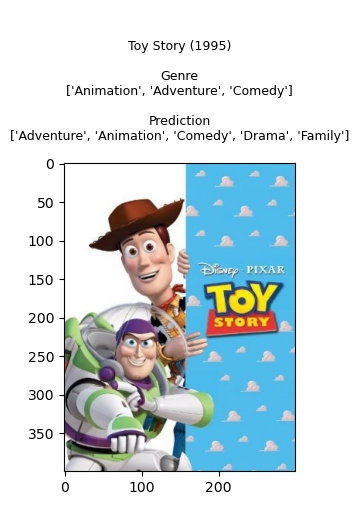

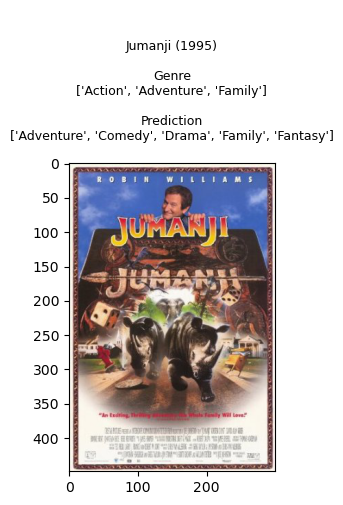

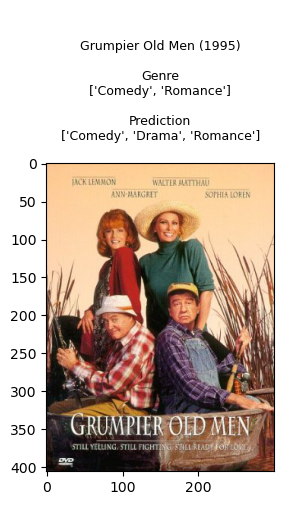

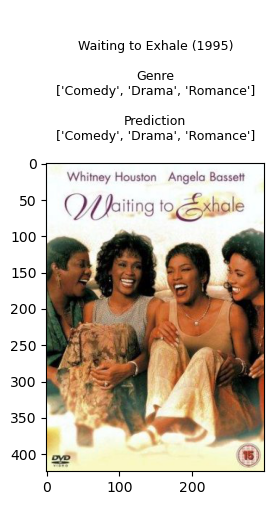

In [26]:
for t in titles:
    show_prediction(t, movie_data, model)

---

### Part 6 - Exporting Model

In [ ]:
export_path = "/home/ec2-user/SageMaker/Models/soft-f1"
tf.compat.v1.keras.experimental.export_saved_model(model, export_path)
print("Model with macro soft-f1 was exported in this path: '{}'".format(export_path))

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
This function will only be available through the v1 compatibility library as tf.compat.v1.saved_model.utils.build_tensor_info or tf.compat.v1.saved_model.build_tensor_info.


Instructions for updating:
This function will only be available through the v1 compatibility library as tf.compat.v1.saved_model.utils.build_tensor_info or tf.compat.v1.saved_model.build_tensor_info.


INFO:tensorflow:Signatures INCLUDED in export for Classify: None


INFO:tensorflow:Signatures INCLUDED in export for Classify: None


INFO:tensorflow:Signatures INCLUDED in export for Regress: None


INFO:tensorflow:Signatures INCLUDED in export for Regress: None


INFO:tensorflow:Signatures INCLUDED in export for Predict: None


INFO:tensorflow:Signatures INCLUDED in export for Predict: None


INFO:tensorflow:Signatures INCLUDED in export for Train: ['train']


INFO:tensorflow:Signatures INCLUDED in export for Train: ['train']


INFO:tensorflow:Signatures INCLUDED in export for Eval: None


INFO:tensorflow:Signatures INCLUDED in export for Eval: None


Type is unsupported, or the types of the items don't match field type in CollectionDef. Note this is a warning and probably safe to ignore.
'list' object has no attribute 'name'


Type is unsupported, or the types of the items don't match field type in CollectionDef. Note this is a warning and probably safe to ignore.
'list' object has no attribute 'name'


INFO:tensorflow:No assets to save.


INFO:tensorflow:No assets to save.


INFO:tensorflow:No assets to write.


INFO:tensorflow:No assets to write.
